# Modeling and Simulation in Python

Project 1 example

Copyright 2018 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

In [2]:
from pandas import read_html

filename = '../data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [3]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    if len(timeseries):
        plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

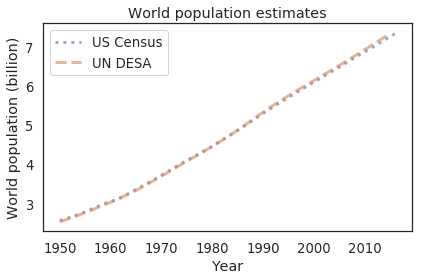

In [4]:
un = table2.un / 1e9
census = table2.census / 1e9
empty = TimeSeries()
plot_results(census, un, empty, 'World population estimates')

### Why is world population growing linearly?

Since 1970, world population has been growing approximately linearly, as shown in the previous figure.  During this time, death and birth rates have decreased in most regions, but it is hard to imagine a mechanism that would cause them to decrease in a way that yields constant net growth year after year.  So why is world population growing linearly?

To explore this question, we will look for a model that reproduces linear growth, and identify the essential features that yield this behavior.

Specifically, we'll add two new features to the model:

1.  Age:  The current model does not account for age; we will extend the model by including two age groups, young and old, roughly corresponding to people younger or older than 40.

2.  The demographic transition:  Birth rates have decreased substantially since 1970.  We model this transition with an abrupt change in 1970 from an initial high level to a lower level.

We'll use the 1950 world population from the US Census as an initial condition, assuming that half the population is young and half old.

In [5]:
half = get_first_value(census) / 2

1.278814327

In [6]:
init = State(young=half, old=half)

,values
young,1.278814
old,1.278814


We'll use a `System` object to store the parameters of the model.

In [7]:
system = System(birth_rate1 = 1/18,
                birth_rate2 = 1/25,
                transition_year = 1970,
                mature_rate = 1/40,
                death_rate = 1/40,
                t_0 = 1950,
                t_end = 2016,
                init=init)

,values
birth_rate1,0.0555556
birth_rate2,0.04
transition_year,1970
mature_rate,0.025
death_rate,0.025
t_0,1950
t_end,2016
init,young 1.278814 old 1.278814 dtype: flo...


Here's an update function that computes the state of the system during the next year, given the current state and time.

In [8]:
def update_func1(state, t, system):
    if t <= system.transition_year:
        births = system.birth_rate1 * state.young
    else:    
        births = system.birth_rate2 * state.young
        
    maturings = system.mature_rate * state.young
    deaths = system.death_rate * state.old
    
    young = state.young + births - maturings
    old = state.old + maturings - deaths
    
    return State(young=young, old=old)

We'll test the update function with the initial condition.

In [9]:
state = update_func1(init, system.t_0, system)

,values
young,1.317889
old,1.278814


And we can do one more update using the state we just computed:

In [10]:
state = update_func1(state, system.t_0, system)

,values
young,1.358158
old,1.279791


The `run_simulation` function is similar to the one in the book; it returns a time series of total population.

In [11]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    init: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    
    state = system.init
    results[system.t_0] = state.young + state.old
    
    for t in linrange(system.t_0, system.t_end):
        state = update_func(state, t, system)
        results[t+1] = state.young + state.old
        
    return results

Now we can run the simulation and plot the results:

In [12]:
results = run_simulation(system, update_func1);

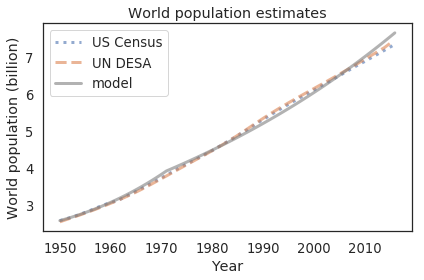

In [13]:
plot_results(census, un, results, 'World population estimates')

This figure shows the results from our model along with world population estimates from the United Nations Department of Economic and Social Affairs (UN DESA) and the US Census Bureau.

We adjusted the parameters by hand to fit the data as well as possible.  Overall, the model fits the data well.

Nevertheless, between 1970 and 2016 there is clear curvature in the model that does not appear in the data, and in the most recent years it looks like the model is diverging from the data.

In particular, the model would predict accelerating growth in the near future, which does not seem consistent with the trend in the data, and it contradicts predictions by experts.

It seems that this model does not explain why world population is growing linear.  We conclude that adding two age groups to the model is not sufficient to produce linear growth.  Modeling the demographic transition with an abrupt change in birth rate is not sufficient either.

In future work, we might explore whether a gradual change in birth rate would work better, possibly using a logistic function.  We also might explore the behavior of the model with more than two age groups.